In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 이미지 불러오기

In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name= 'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='~/aiffel/lms/node/',
    download=True,  # Change this to True to download the dataset
    with_info=True,
    as_supervised=True,
)

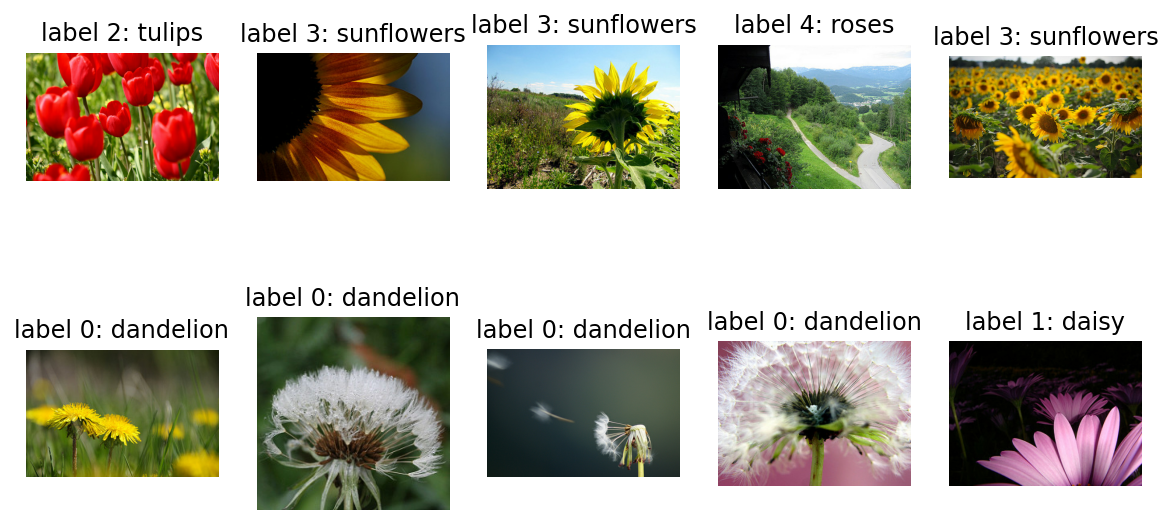

In [3]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [4]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정(-1~1)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [5]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [6]:
BATCH_SIZE = 32  #한 스텝에 학습시킬 데이터의 개수
SHUFFLE_BUFFER_SIZE = 1000  #학습 데이터를 적절히 섞어줌

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

# VGG-16

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [8]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,  # classification layer을 빼고 불러오기 위해
                                         weights='imagenet')

In [9]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = Dense(units = 512, activation = 'relu')
prediction_layer = Dense(units = 5, activation = 'softmax')

base_model.trainable = False

model16_1 = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

### learning rate = 0.001

In [10]:
model16_1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [31]:
model16_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
# 학습 전 base model 성능 확인
validation_steps=20
loss0, accuracy0 = model16_1.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/20 [=================>............] - ETA: 1s - loss: 1.6669 - accuracy: 0.1771WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


20/20 [==============================] - 9s 142ms/step - loss: 1.6669 - accuracy: 0.1771
initial loss: 1.67
initial accuracy: 0.18


In [12]:
EPOCHS = 10
history16_1 = model16_1.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 13s 119ms/step - loss: 0.8813 - accuracy: 0.6710 - val_loss: 0.6148 - val_accuracy: 0.7711
Epoch 2/10
92/92 [==============================] - 8s 83ms/step - loss: 0.5922 - accuracy: 0.7919 - val_loss: 0.5806 - val_accuracy: 0.7820
Epoch 3/10
92/92 [==============================] - 8s 84ms/step - loss: 0.4948 - accuracy: 0.8297 - val_loss: 0.5878 - val_accuracy: 0.7820
Epoch 4/10
92/92 [==============================] - 8s 84ms/step - loss: 0.4562 - accuracy: 0.8358 - val_loss: 0.5078 - val_accuracy: 0.8093
Epoch 5/10
92/92 [==============================] - 8s 83ms/step - loss: 0.4145 - accuracy: 0.8546 - val_loss: 0.4668 - val_accuracy: 0.8474
Epoch 6/10
92/92 [==============================] - 8s 82ms/step - loss: 0.3750 - accuracy: 0.8638 - val_loss: 0.5099 - val_accuracy: 0.8038
Epoch 7/10
92/92 [==============================] - 8s 81ms/step - loss: 0.3495 - accuracy: 0.8784 - val_loss: 0.4991 - val_accuracy: 0.8202
Epoch 8/10


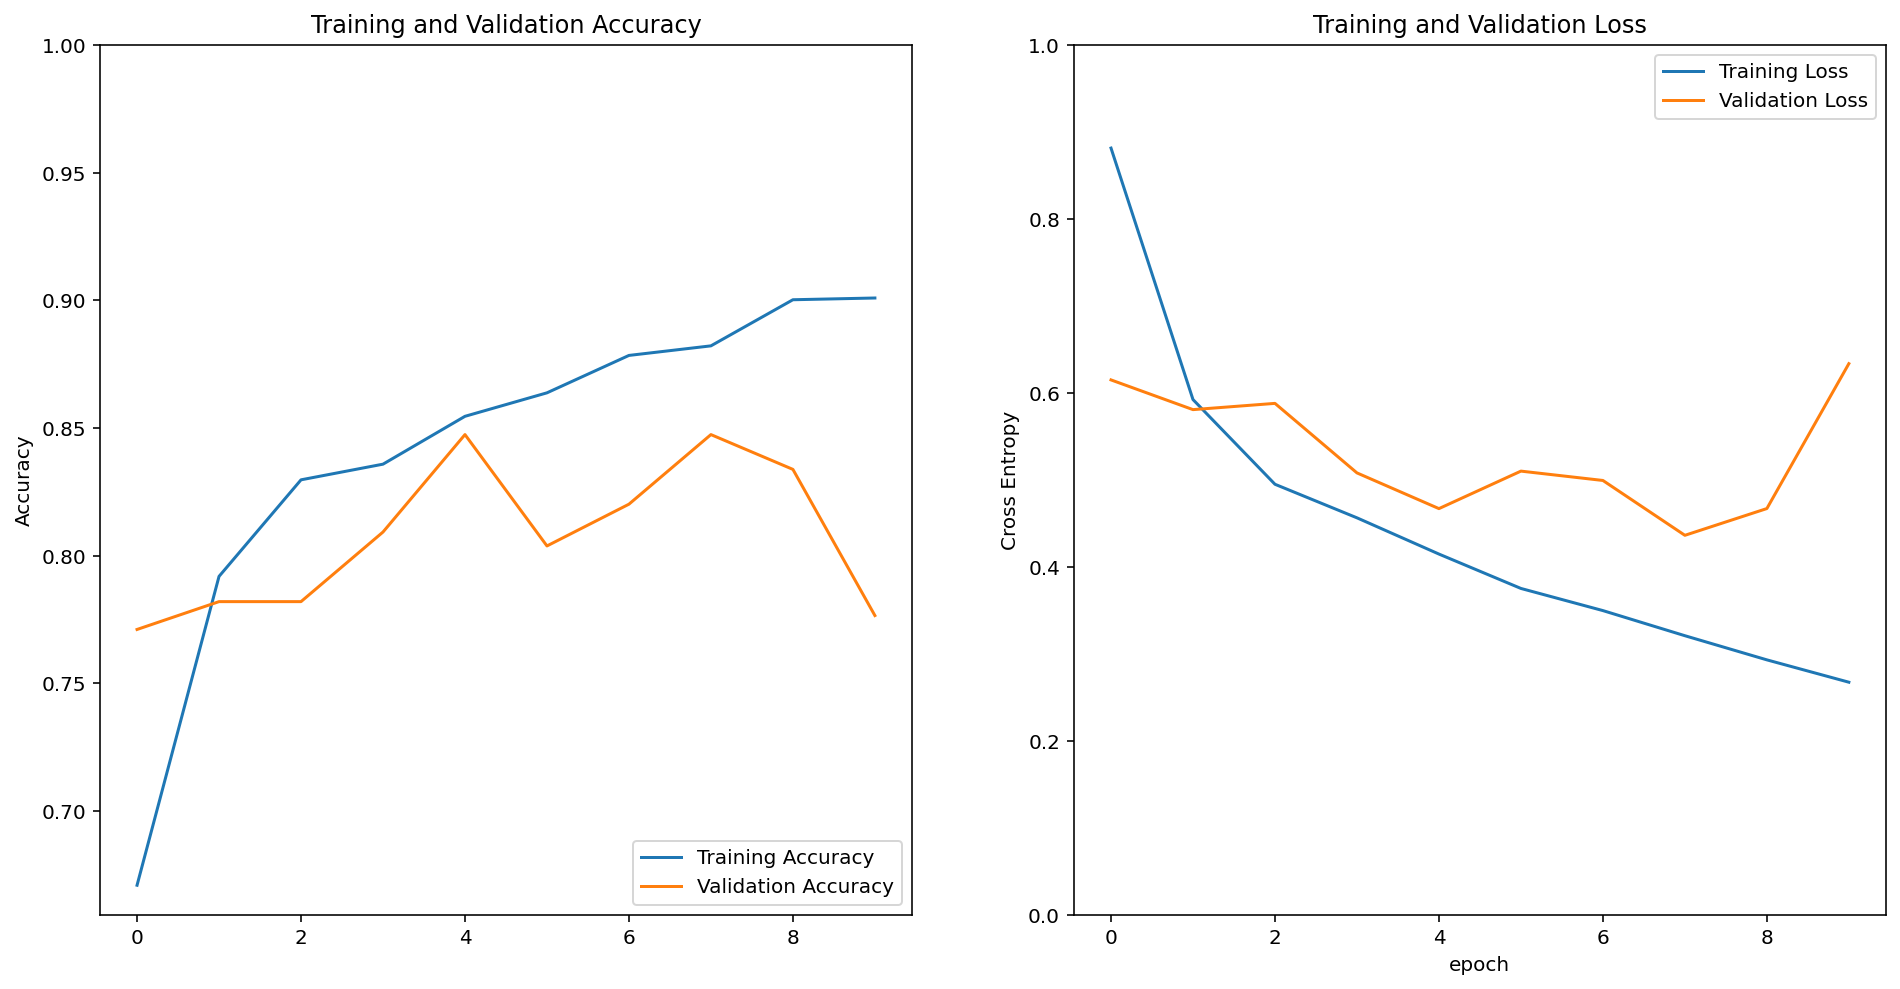

In [13]:
acc = history16_1.history['accuracy']
val_acc = history16_1.history['val_accuracy']

loss = history16_1.history['loss']
val_loss = history16_1.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
results = model16_1.evaluate(test_batches)
print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

12/12 [==============================] - 1s 64ms/step - loss: 0.4976 - accuracy: 0.8229
Test Loss: 0.49762171506881714
Test Accuracy: 0.8228882551193237


### learning rate 0.0001

In [17]:
learning_rate = 0.0001

model16_2 = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

model16_2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [18]:
EPOCHS = 10
history16_2 = model16_2.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 9s 83ms/step - loss: 0.2046 - accuracy: 0.9363 - val_loss: 0.4287 - val_accuracy: 0.8501
Epoch 2/10
92/92 [==============================] - 8s 82ms/step - loss: 0.1884 - accuracy: 0.9428 - val_loss: 0.4339 - val_accuracy: 0.8556
Epoch 3/10
92/92 [==============================] - 8s 83ms/step - loss: 0.1852 - accuracy: 0.9418 - val_loss: 0.4350 - val_accuracy: 0.8556
Epoch 4/10
92/92 [==============================] - 8s 84ms/step - loss: 0.1810 - accuracy: 0.9421 - val_loss: 0.4378 - val_accuracy: 0.8474
Epoch 5/10
92/92 [==============================] - 8s 83ms/step - loss: 0.1782 - accuracy: 0.9438 - val_loss: 0.4365 - val_accuracy: 0.8556
Epoch 6/10
92/92 [==============================] - 8s 83ms/step - loss: 0.1747 - accuracy: 0.9465 - val_loss: 0.4281 - val_accuracy: 0.8638
Epoch 7/10
92/92 [==============================] - 8s 82ms/step - loss: 0.1717 - accuracy: 0.9482 - val_loss: 0.4291 - val_accuracy: 0.8665
Epoch 8/10
92

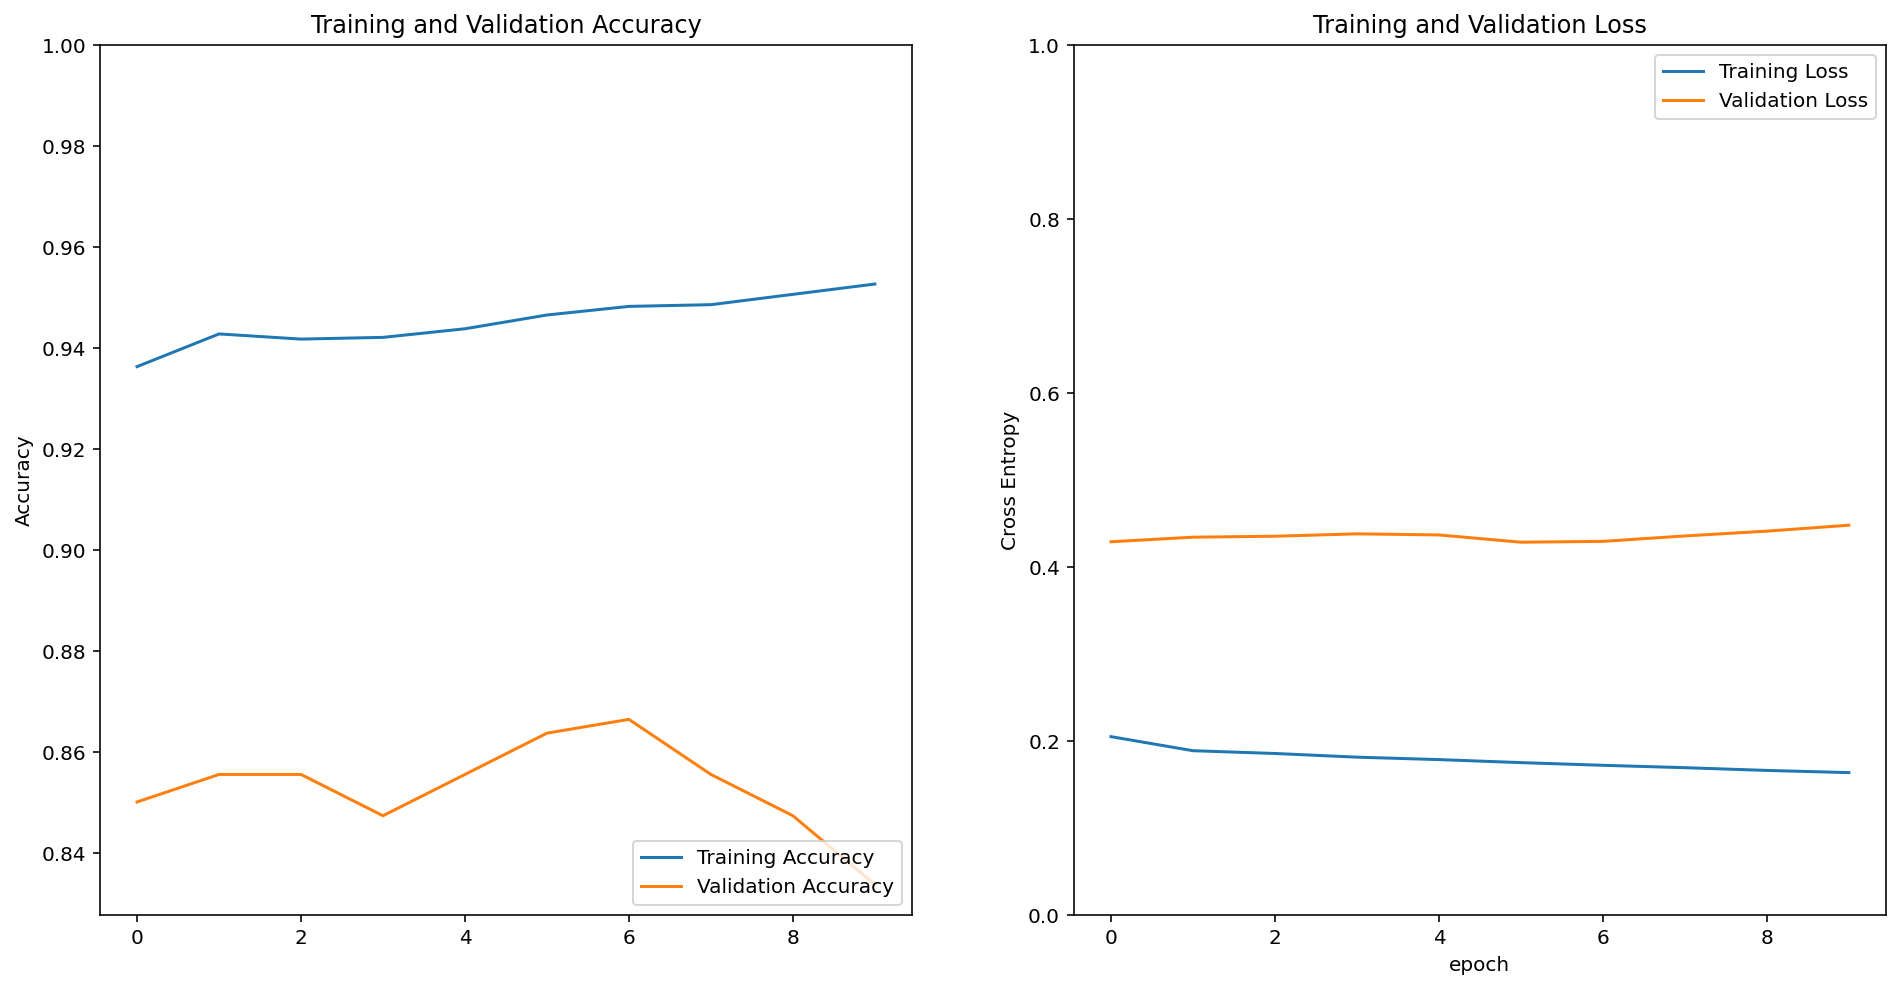

In [19]:
acc = history16_2.history['accuracy']
val_acc = history16_2.history['val_accuracy']

loss = history16_2.history['loss']
val_loss = history16_2.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
results = model16_2.evaluate(test_batches)
print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

12/12 [==============================] - 1s 63ms/step - loss: 0.3892 - accuracy: 0.8610
Test Loss: 0.3892079293727875
Test Accuracy: 0.8610354065895081


# VGG-19

### 1. learning rate 0.001(디폴트)

In [145]:
BATCH_SIZE = 32  #한 스텝에 학습시킬 데이터의 개수
SHUFFLE_BUFFER_SIZE = 1000  #학습 데이터를 적절히 섞어줌

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [146]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                         include_top=False,  # classification layer을 빼고 불러오기 위해
                                         weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = Dense(units = 512, activation = 'relu')
prediction_layer = Dense(units = 5, activation = 'softmax')

base_model.trainable = False


In [147]:
model19_1 = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

learning_rate = 0.001

model19_1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [148]:
model19_1.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 5, 5, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 2565      
Total params: 20,289,605
Trainable params: 265,221
Non-trainable params: 20,024,384
_________________________________________________________________


In [149]:
validation_steps=20
loss0, accuracy0 = model19_1.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

11/20 [===============>..............] - ETA: 0s - loss: 1.7899 - accuracy: 0.1506WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


20/20 [==============================] - 1s 46ms/step - loss: 1.7958 - accuracy: 0.1499
initial loss: 1.80
initial accuracy: 0.15


In [150]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

checkpoint_path = "vgg19_base.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose =1)
]

history19_1 = model19_1.fit(train_batches,
                    epochs=50,
                    validation_data=validation_batches,
                    callbacks=keras_callbacks)

Epoch 1/50
92/92 [==============================] - 10s 98ms/step - loss: 0.9490 - accuracy: 0.6431 - val_loss: 0.8271 - val_accuracy: 0.6730

Epoch 00001: val_loss improved from inf to 0.82710, saving model to vgg19_base.keras
Epoch 2/50
92/92 [==============================] - 10s 100ms/step - loss: 0.6558 - accuracy: 0.7602 - val_loss: 0.6817 - val_accuracy: 0.7548

Epoch 00002: val_loss improved from 0.82710 to 0.68169, saving model to vgg19_base.keras
Epoch 3/50
92/92 [==============================] - 10s 101ms/step - loss: 0.5604 - accuracy: 0.8021 - val_loss: 0.6442 - val_accuracy: 0.7820

Epoch 00003: val_loss improved from 0.68169 to 0.64421, saving model to vgg19_base.keras
Epoch 4/50
92/92 [==============================] - 9s 98ms/step - loss: 0.5163 - accuracy: 0.8096 - val_loss: 0.6904 - val_accuracy: 0.7629

Epoch 00004: val_loss did not improve from 0.64421
Epoch 5/50
92/92 [==============================] - 9s 97ms/step - loss: 0.4754 - accuracy: 0.8202 - val_loss: 0.

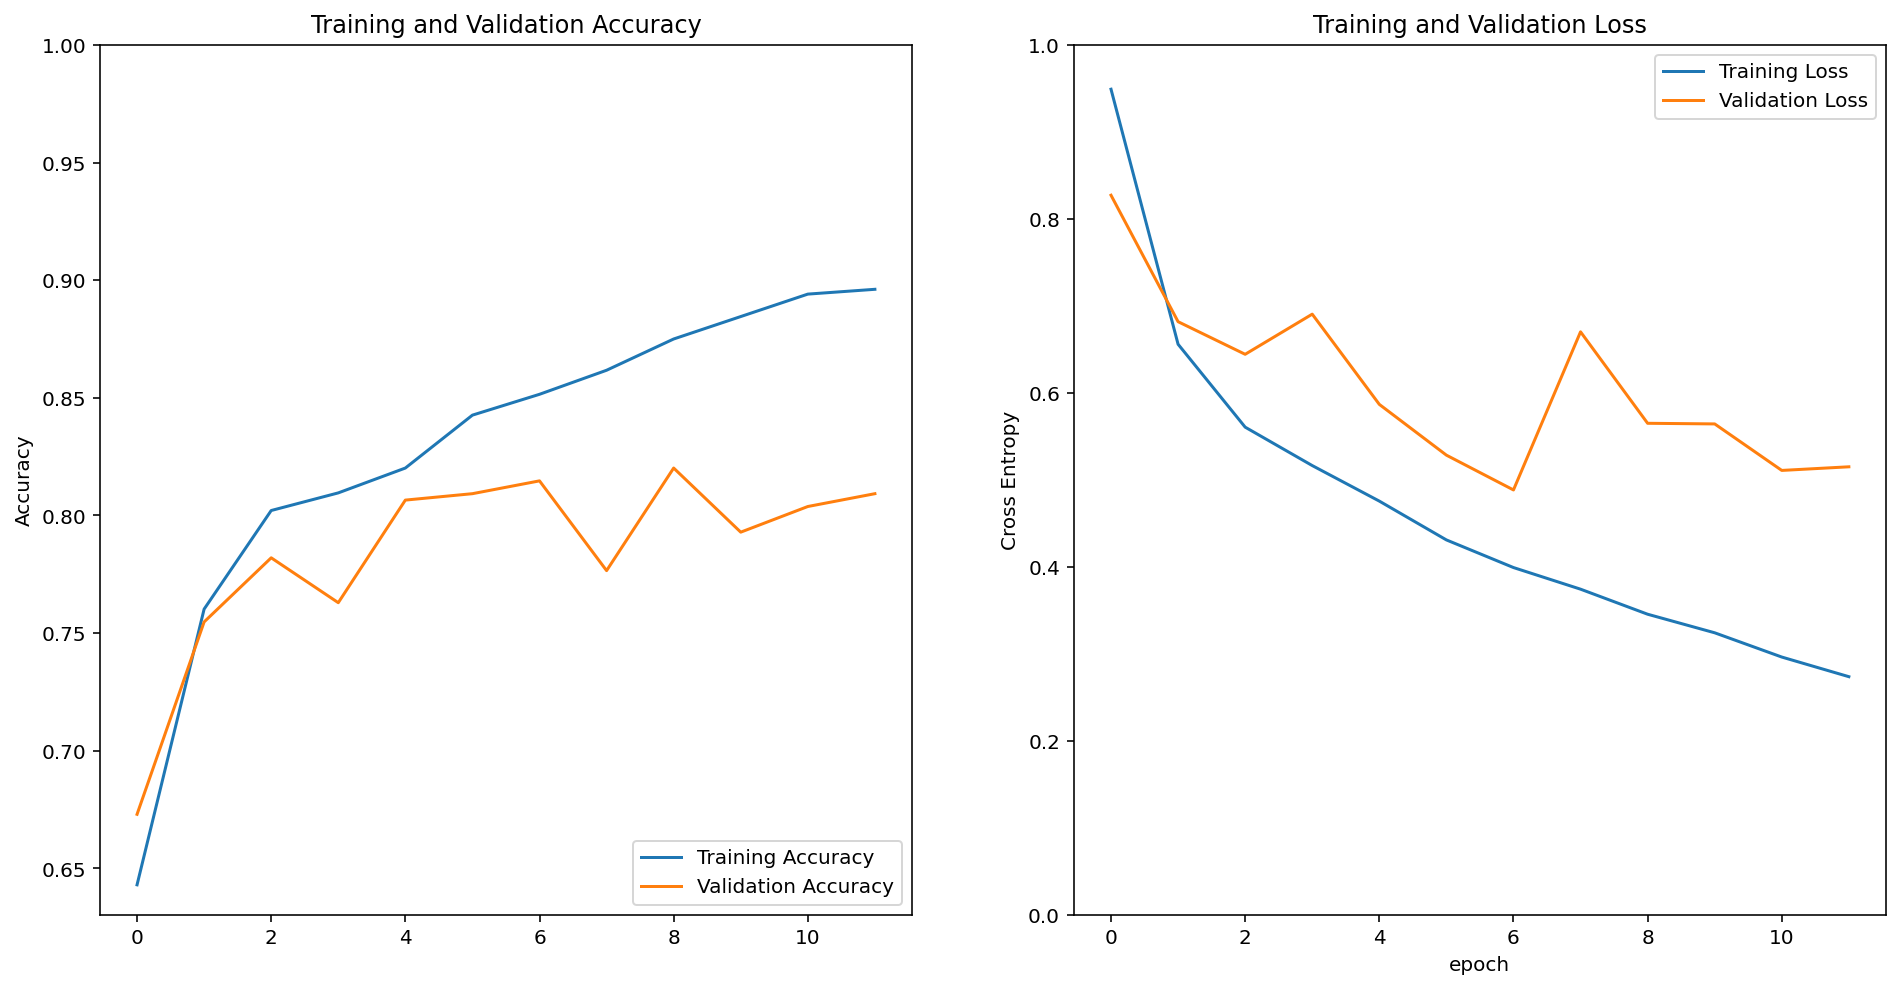

In [151]:
acc = history19_1.history['accuracy']
val_acc = history19_1.history['val_accuracy']

loss = history19_1.history['loss']
val_loss = history19_1.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [154]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# 체크포인트에서 모델을 로드
checkpoint_path = "vgg19_base.keras"
model19_1_1 = load_model(checkpoint_path)

# 로드된 모델을 사용하여 평가
test_loss, test_accuracy = model19_1_1.evaluate(test_batches)

# 결과 출력
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

import numpy as np

# tf.function으로 감싸서 retracing을 방지
@tf.function
def predict_batch(model, image_batch):
    return model(image_batch, training=False)

# 배치에서 이미지를 가져옴
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = predict_batch(model19_1_1, image_batch)
    break

# 예측값에서 가장 높은 확률의 인덱스를 가져옴
predictions = np.argmax(predictions, axis=1)

# 정답을 맞춘 개수를 계산
count = np.sum(labels.numpy() == predictions)

# 정확도 계산 및 출력
accuracy = count / len(labels) * 100
print(accuracy)

12/12 [==============================] - 1s 78ms/step - loss: 0.5118 - accuracy: 0.8202
Test Loss: 0.5117982029914856
Test Accuracy: 82.02%
87.5


### 2. learning rate 0.0001

In [155]:
BATCH_SIZE = 32  #한 스텝에 학습시킬 데이터의 개수
SHUFFLE_BUFFER_SIZE = 1000  #학습 데이터를 적절히 섞어줌

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [156]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                         include_top=False,  # classification layer을 빼고 불러오기 위해
                                         weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = Dense(units = 512, activation = 'relu')
prediction_layer = Dense(units = 5, activation = 'softmax')

base_model.trainable = False


In [157]:
model19_2 = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

learning_rate = 0.0001

model19_2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [158]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

checkpoint_path = "vgg19_0.0001.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose =1)
]

history19_2 = model19_2.fit(train_batches,
                    epochs=50,
                    validation_data=validation_batches,
                    callbacks=keras_callbacks)

Epoch 1/50
92/92 [==============================] - 10s 99ms/step - loss: 1.3952 - accuracy: 0.4874 - val_loss: 1.1987 - val_accuracy: 0.6649

Epoch 00001: val_loss improved from inf to 1.19875, saving model to vgg19_0.0001.keras
Epoch 2/50
92/92 [==============================] - 9s 98ms/step - loss: 1.0847 - accuracy: 0.6907 - val_loss: 0.9636 - val_accuracy: 0.7221

Epoch 00002: val_loss improved from 1.19875 to 0.96358, saving model to vgg19_0.0001.keras
Epoch 3/50
92/92 [==============================] - 10s 100ms/step - loss: 0.9094 - accuracy: 0.7258 - val_loss: 0.8413 - val_accuracy: 0.7629

Epoch 00003: val_loss improved from 0.96358 to 0.84125, saving model to vgg19_0.0001.keras
Epoch 4/50
92/92 [==============================] - 10s 100ms/step - loss: 0.8045 - accuracy: 0.7493 - val_loss: 0.7657 - val_accuracy: 0.7738

Epoch 00004: val_loss improved from 0.84125 to 0.76568, saving model to vgg19_0.0001.keras
Epoch 5/50
92/92 [==============================] - 9s 98ms/step - 

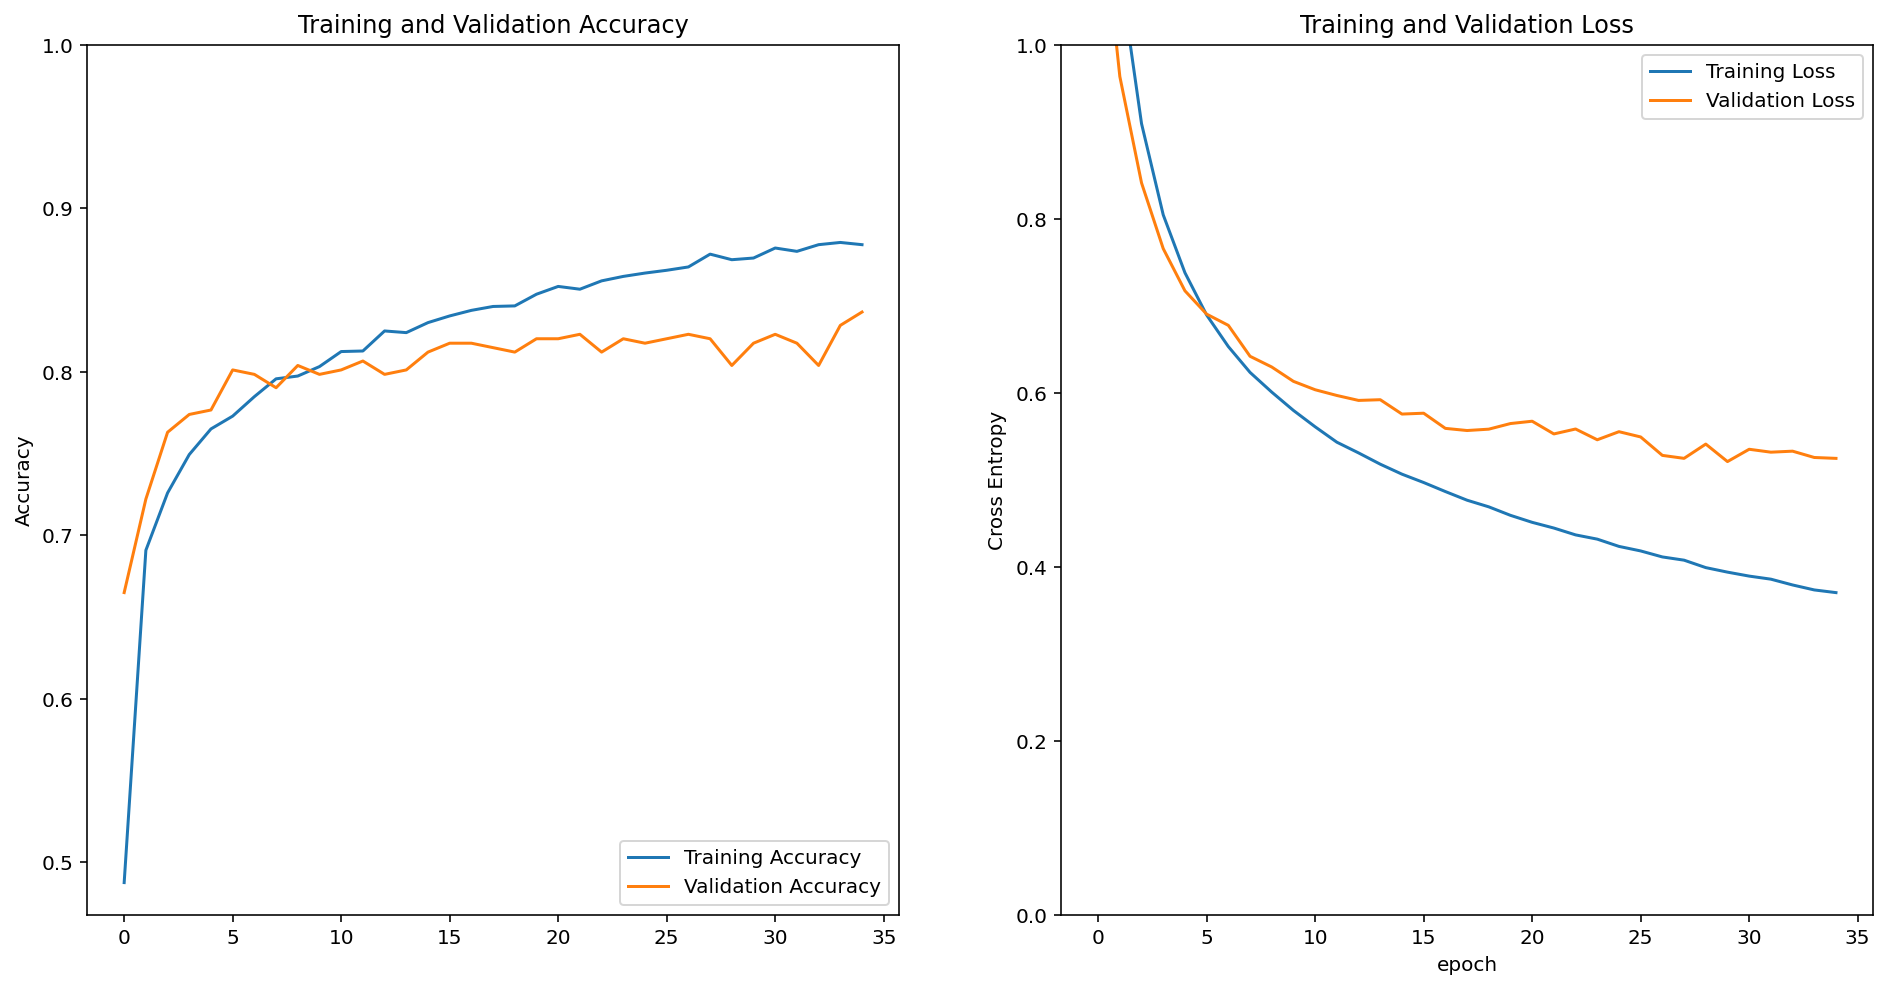

In [159]:
acc = history19_2.history['accuracy']
val_acc = history19_2.history['val_accuracy']

loss = history19_2.history['loss']
val_loss = history19_2.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [160]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# 체크포인트에서 모델을 로드
checkpoint_path = "vgg19_0.0001.keras"
model19_1_1 = load_model(checkpoint_path)

# 로드된 모델을 사용하여 평가
test_loss, test_accuracy = model19_1_1.evaluate(test_batches)

# 결과 출력
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

import numpy as np

# tf.function으로 감싸서 retracing을 방지
@tf.function
def predict_batch(model, image_batch):
    return model(image_batch, training=False)

# 배치에서 이미지를 가져옴
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = predict_batch(model19_1_1, image_batch)
    break

# 예측값에서 가장 높은 확률의 인덱스를 가져옴
predictions = np.argmax(predictions, axis=1)

# 정답을 맞춘 개수를 계산
count = np.sum(labels.numpy() == predictions)

# 정확도 계산 및 출력
accuracy = count / len(labels) * 100
print(accuracy)

12/12 [==============================] - 1s 78ms/step - loss: 0.5156 - accuracy: 0.8229
Test Loss: 0.5156471133232117
Test Accuracy: 82.29%
87.5


### 3. batch size 32->64

In [161]:
BATCH_SIZE = 64  #한 스텝에 학습시킬 데이터의 개수
SHUFFLE_BUFFER_SIZE = 1000  #학습 데이터를 적절히 섞어줌

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [162]:
model19_3 = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

learning_rate = 0.0001

model19_3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [163]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

checkpoint_path = "vgg19_batch64.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose =1)
]

history19_3 = model19_3.fit(train_batches,
                    epochs=50,
                    validation_data=validation_batches,
                    callbacks=keras_callbacks)

Epoch 1/50
46/46 [==============================] - 10s 198ms/step - loss: 0.3632 - accuracy: 0.8845 - val_loss: 0.5165 - val_accuracy: 0.8202

Epoch 00001: val_loss improved from inf to 0.51653, saving model to vgg19_batch64.keras
Epoch 2/50
46/46 [==============================] - 9s 193ms/step - loss: 0.3572 - accuracy: 0.8811 - val_loss: 0.5203 - val_accuracy: 0.8283

Epoch 00002: val_loss did not improve from 0.51653
Epoch 3/50
46/46 [==============================] - 9s 193ms/step - loss: 0.3551 - accuracy: 0.8879 - val_loss: 0.5150 - val_accuracy: 0.8365

Epoch 00003: val_loss improved from 0.51653 to 0.51496, saving model to vgg19_batch64.keras
Epoch 4/50
46/46 [==============================] - 9s 194ms/step - loss: 0.3527 - accuracy: 0.8869 - val_loss: 0.5072 - val_accuracy: 0.8311

Epoch 00004: val_loss improved from 0.51496 to 0.50720, saving model to vgg19_batch64.keras
Epoch 5/50
46/46 [==============================] - 9s 195ms/step - loss: 0.3476 - accuracy: 0.8883 - va

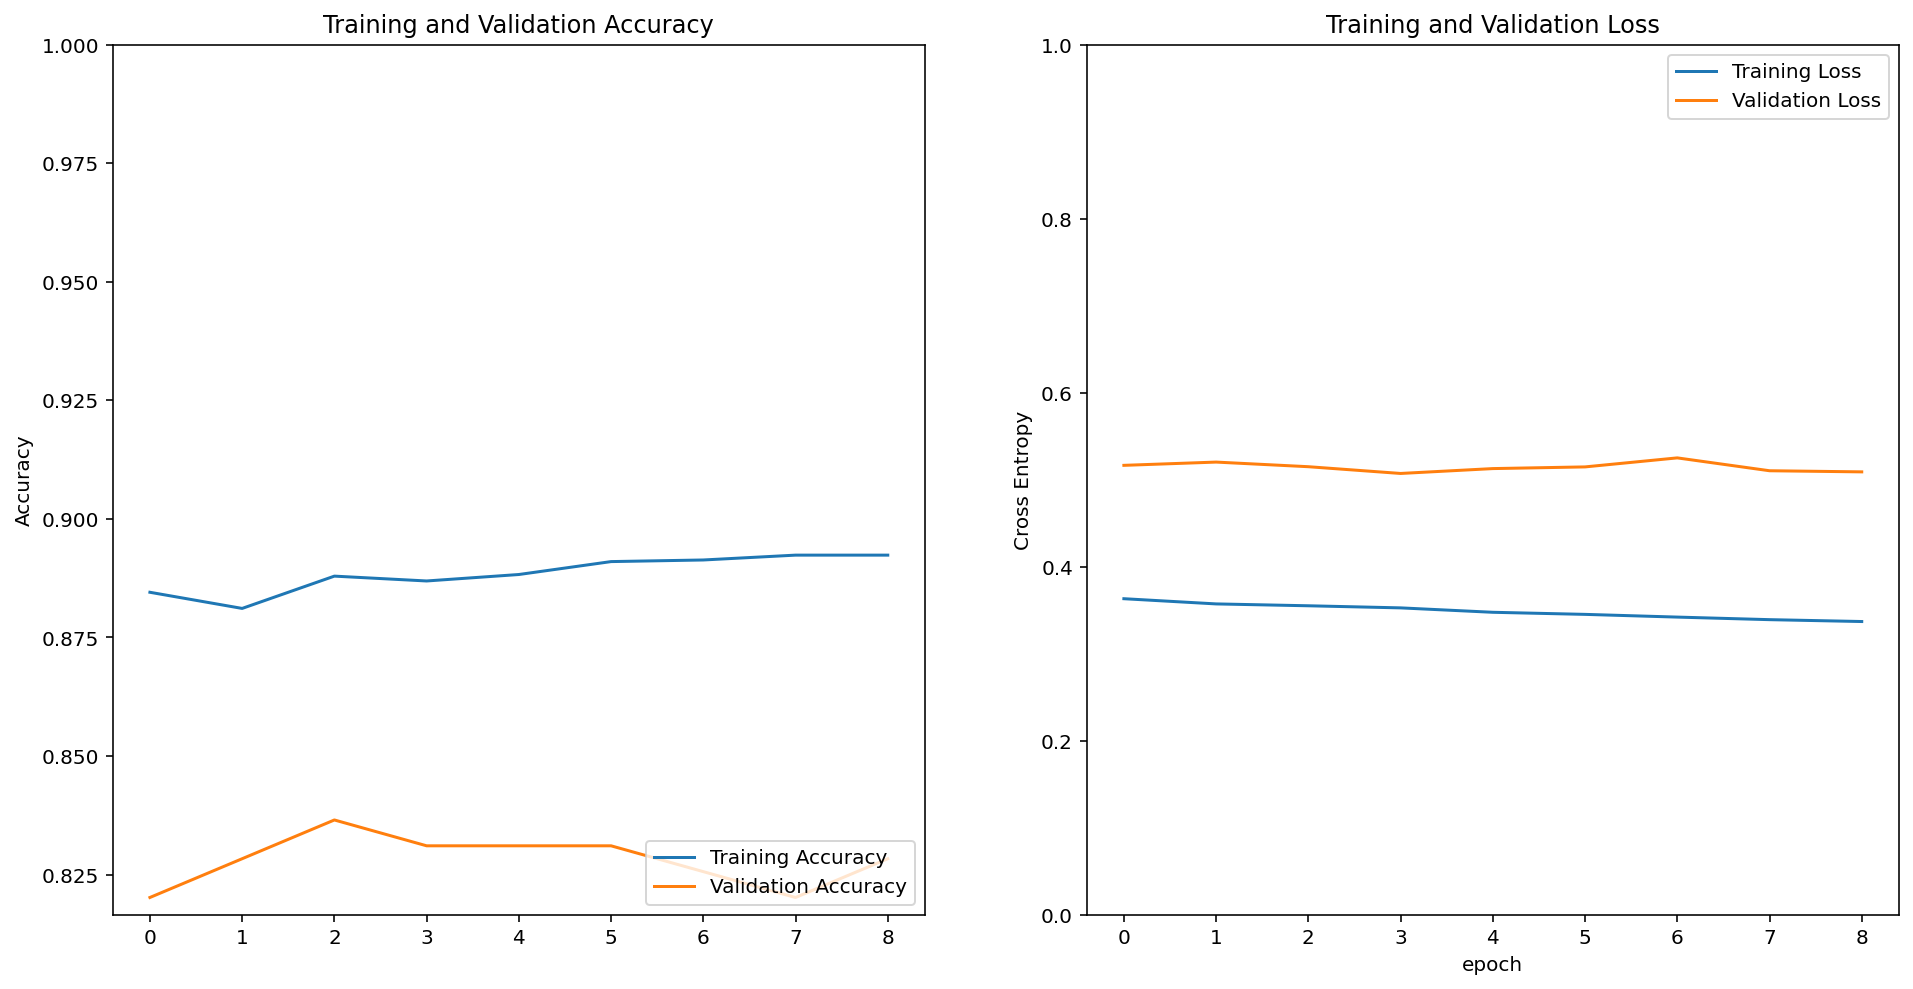

In [164]:
acc = history19_3.history['accuracy']
val_acc = history19_3.history['val_accuracy']

loss = history19_3.history['loss']
val_loss = history19_3.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [165]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# 체크포인트에서 모델을 로드
checkpoint_path = "vgg19_batch64.keras"
model19_1_1 = load_model(checkpoint_path)

# 로드된 모델을 사용하여 평가
test_loss, test_accuracy = model19_1_1.evaluate(test_batches)

# 결과 출력
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

import numpy as np

# tf.function으로 감싸서 retracing을 방지
@tf.function
def predict_batch(model, image_batch):
    return model(image_batch, training=False)

# 배치에서 이미지를 가져옴
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = predict_batch(model19_1_1, image_batch)
    break

# 예측값에서 가장 높은 확률의 인덱스를 가져옴
predictions = np.argmax(predictions, axis=1)

# 정답을 맞춘 개수를 계산
count = np.sum(labels.numpy() == predictions)

# 정확도 계산 및 출력
accuracy = count / len(labels) * 100
print(accuracy)

6/6 [==============================] - 1s 150ms/step - loss: 0.5083 - accuracy: 0.8174
Test Loss: 0.5082871913909912
Test Accuracy: 81.74%
73.4375


### 4. learing rate 0.001, batch size 32->64

In [166]:
BATCH_SIZE = 64  #한 스텝에 학습시킬 데이터의 개수
SHUFFLE_BUFFER_SIZE = 1000  #학습 데이터를 적절히 섞어줌

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [167]:
model19_4 = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

learning_rate = 0.001

model19_4.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [168]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

checkpoint_path = "vgg19_batch64_001.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose =1)
]

history19_4 = model19_4.fit(train_batches,
                    epochs=50,
                    validation_data=validation_batches,
                    callbacks=keras_callbacks)

Epoch 1/50
46/46 [==============================] - 10s 198ms/step - loss: 0.4736 - accuracy: 0.8369 - val_loss: 0.5532 - val_accuracy: 0.8065

Epoch 00001: val_loss improved from inf to 0.55322, saving model to vgg19_batch64_001.keras
Epoch 2/50
46/46 [==============================] - 9s 195ms/step - loss: 0.3963 - accuracy: 0.8597 - val_loss: 0.5633 - val_accuracy: 0.8174

Epoch 00002: val_loss did not improve from 0.55322
Epoch 3/50
46/46 [==============================] - 9s 195ms/step - loss: 0.3882 - accuracy: 0.8539 - val_loss: 0.5710 - val_accuracy: 0.8065

Epoch 00003: val_loss did not improve from 0.55322
Epoch 4/50
46/46 [==============================] - 9s 196ms/step - loss: 0.3660 - accuracy: 0.8617 - val_loss: 0.5653 - val_accuracy: 0.8256

Epoch 00004: val_loss did not improve from 0.55322
Epoch 5/50
46/46 [==============================] - 9s 195ms/step - loss: 0.3514 - accuracy: 0.8764 - val_loss: 0.6525 - val_accuracy: 0.7902

Epoch 00005: val_loss did not improve f

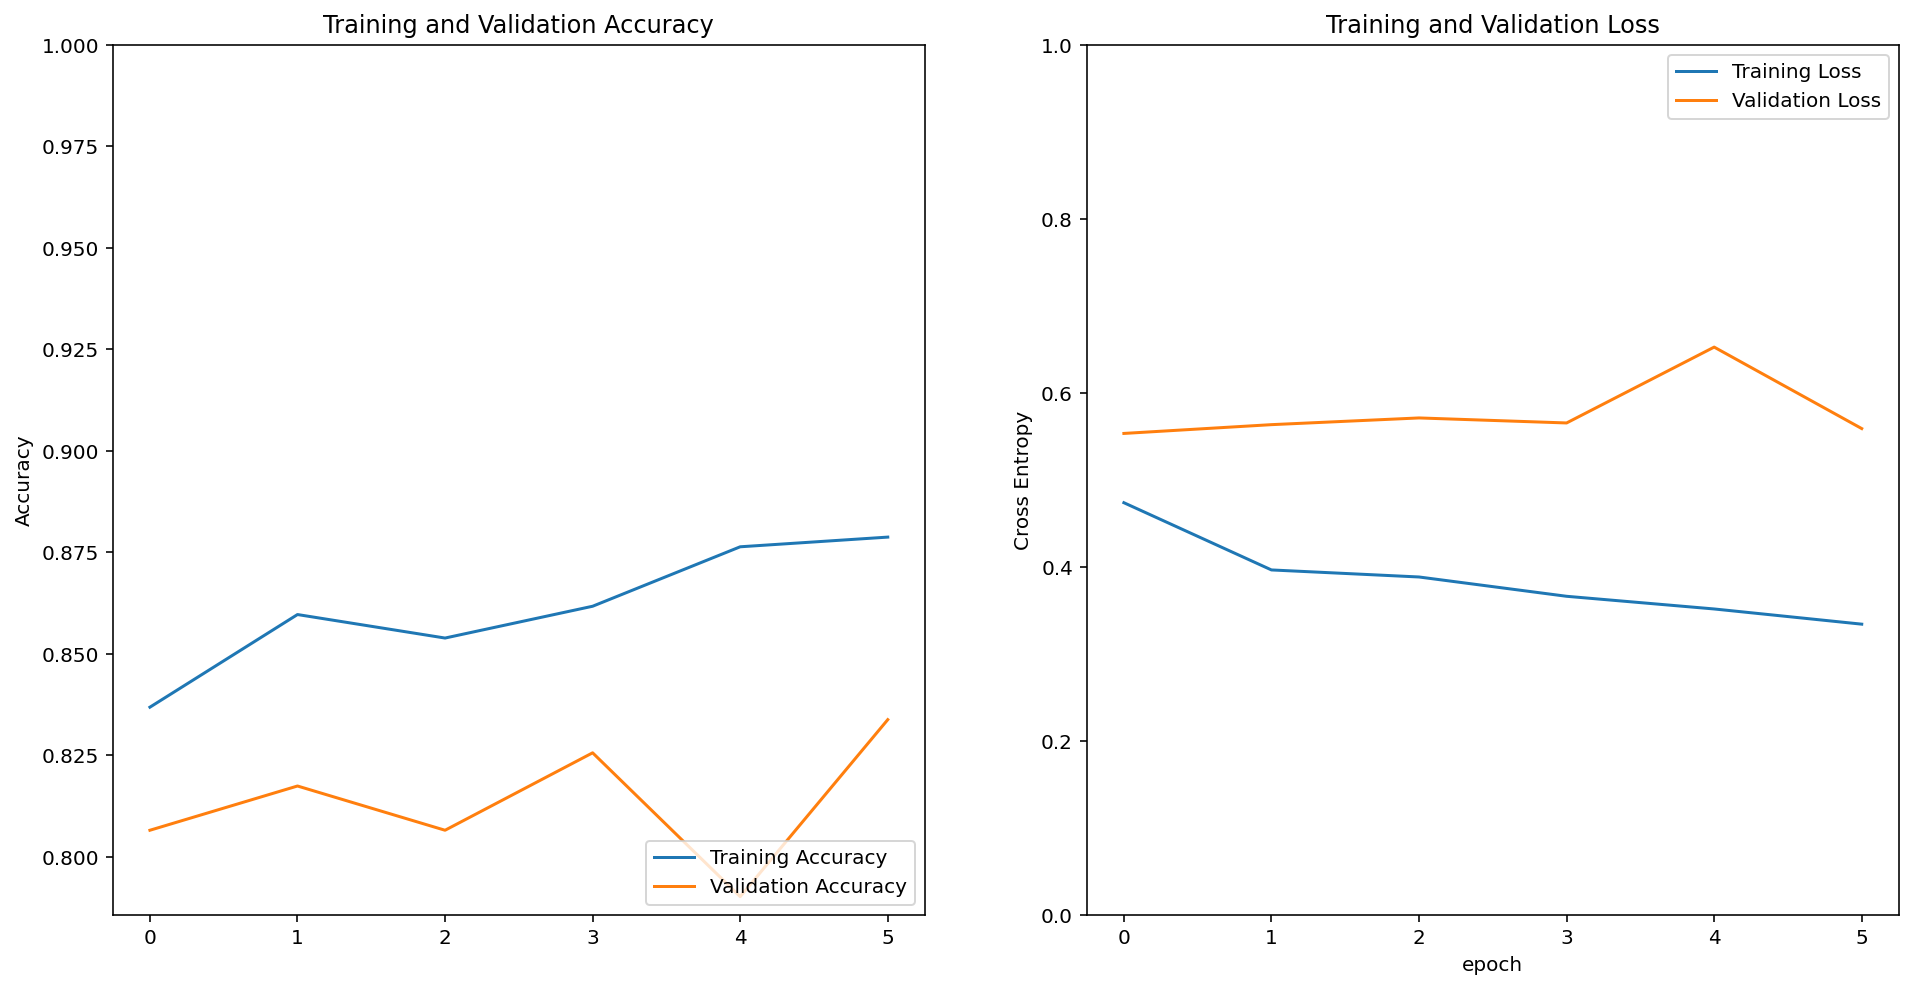

In [169]:
acc = history19_4.history['accuracy']
val_acc = history19_4.history['val_accuracy']

loss = history19_4.history['loss']
val_loss = history19_4.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [170]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# 체크포인트에서 모델을 로드
checkpoint_path = "vgg19_batch64_001.keras"
model19_1_1 = load_model(checkpoint_path)

# 로드된 모델을 사용하여 평가
test_loss, test_accuracy = model19_1_1.evaluate(test_batches)

# 결과 출력
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

import numpy as np

# tf.function으로 감싸서 retracing을 방지
@tf.function
def predict_batch(model, image_batch):
    return model(image_batch, training=False)

# 배치에서 이미지를 가져옴
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = predict_batch(model19_1_1, image_batch)
    break

# 예측값에서 가장 높은 확률의 인덱스를 가져옴
predictions = np.argmax(predictions, axis=1)

# 정답을 맞춘 개수를 계산
count = np.sum(labels.numpy() == predictions)

# 정확도 계산 및 출력
accuracy = count / len(labels) * 100
print(accuracy)

6/6 [==============================] - 1s 149ms/step - loss: 0.6070 - accuracy: 0.7738
Test Loss: 0.6069817543029785
Test Accuracy: 77.38%
64.0625


### 5. dense layer 256*256, batch 32, learning rate 0.0001

In [171]:
BATCH_SIZE = 32  #한 스텝에 학습시킬 데이터의 개수
SHUFFLE_BUFFER_SIZE = 1000  #학습 데이터를 적절히 섞어줌

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [172]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                         include_top=False,  # classification layer을 빼고 불러오기 위해
                                         weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = Dense(units = 256, activation = 'relu')
dense_layer = Dense(units = 256, activation = 'relu')
prediction_layer = Dense(units = 5, activation = 'softmax')

base_model.trainable = False


In [173]:
model19_5 = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

learning_rate = 0.0001

model19_5.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [174]:
model19_5.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 5, 5, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_11  (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 1285      
Total params: 20,156,997
Trainable params: 132,613
Non-trainable params: 20,024,384
_________________________________________________________________


In [175]:
validation_steps=20
loss0, accuracy0 = model19_5.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/20 [=================>............] - ETA: 0s - loss: 1.7037 - accuracy: 0.2480WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


20/20 [==============================] - 1s 47ms/step - loss: 1.7037 - accuracy: 0.2480
initial loss: 1.70
initial accuracy: 0.25


In [176]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

checkpoint_path = "vgg19_64_256256_0001.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=3, mode='min', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose =1)
]

history19_5 = model19_5.fit(train_batches,
                    epochs=50,
                    validation_data=validation_batches,
                    callbacks=keras_callbacks)

Epoch 1/50
92/92 [==============================] - 10s 97ms/step - loss: 1.4630 - accuracy: 0.4387 - val_loss: 1.2906 - val_accuracy: 0.6485

Epoch 00001: val_loss improved from inf to 1.29056, saving model to vgg19_64_256256_0001.keras
Epoch 2/50
92/92 [==============================] - 9s 97ms/step - loss: 1.1954 - accuracy: 0.6437 - val_loss: 1.0929 - val_accuracy: 0.6921

Epoch 00002: val_loss improved from 1.29056 to 1.09295, saving model to vgg19_64_256256_0001.keras
Epoch 3/50
92/92 [==============================] - 9s 97ms/step - loss: 1.0279 - accuracy: 0.6975 - val_loss: 0.9381 - val_accuracy: 0.7384

Epoch 00003: val_loss improved from 1.09295 to 0.93809, saving model to vgg19_64_256256_0001.keras
Epoch 4/50
92/92 [==============================] - 9s 97ms/step - loss: 0.9154 - accuracy: 0.7170 - val_loss: 0.8584 - val_accuracy: 0.7575

Epoch 00004: val_loss improved from 0.93809 to 0.85837, saving model to vgg19_64_256256_0001.keras
Epoch 5/50
92/92 [=====================

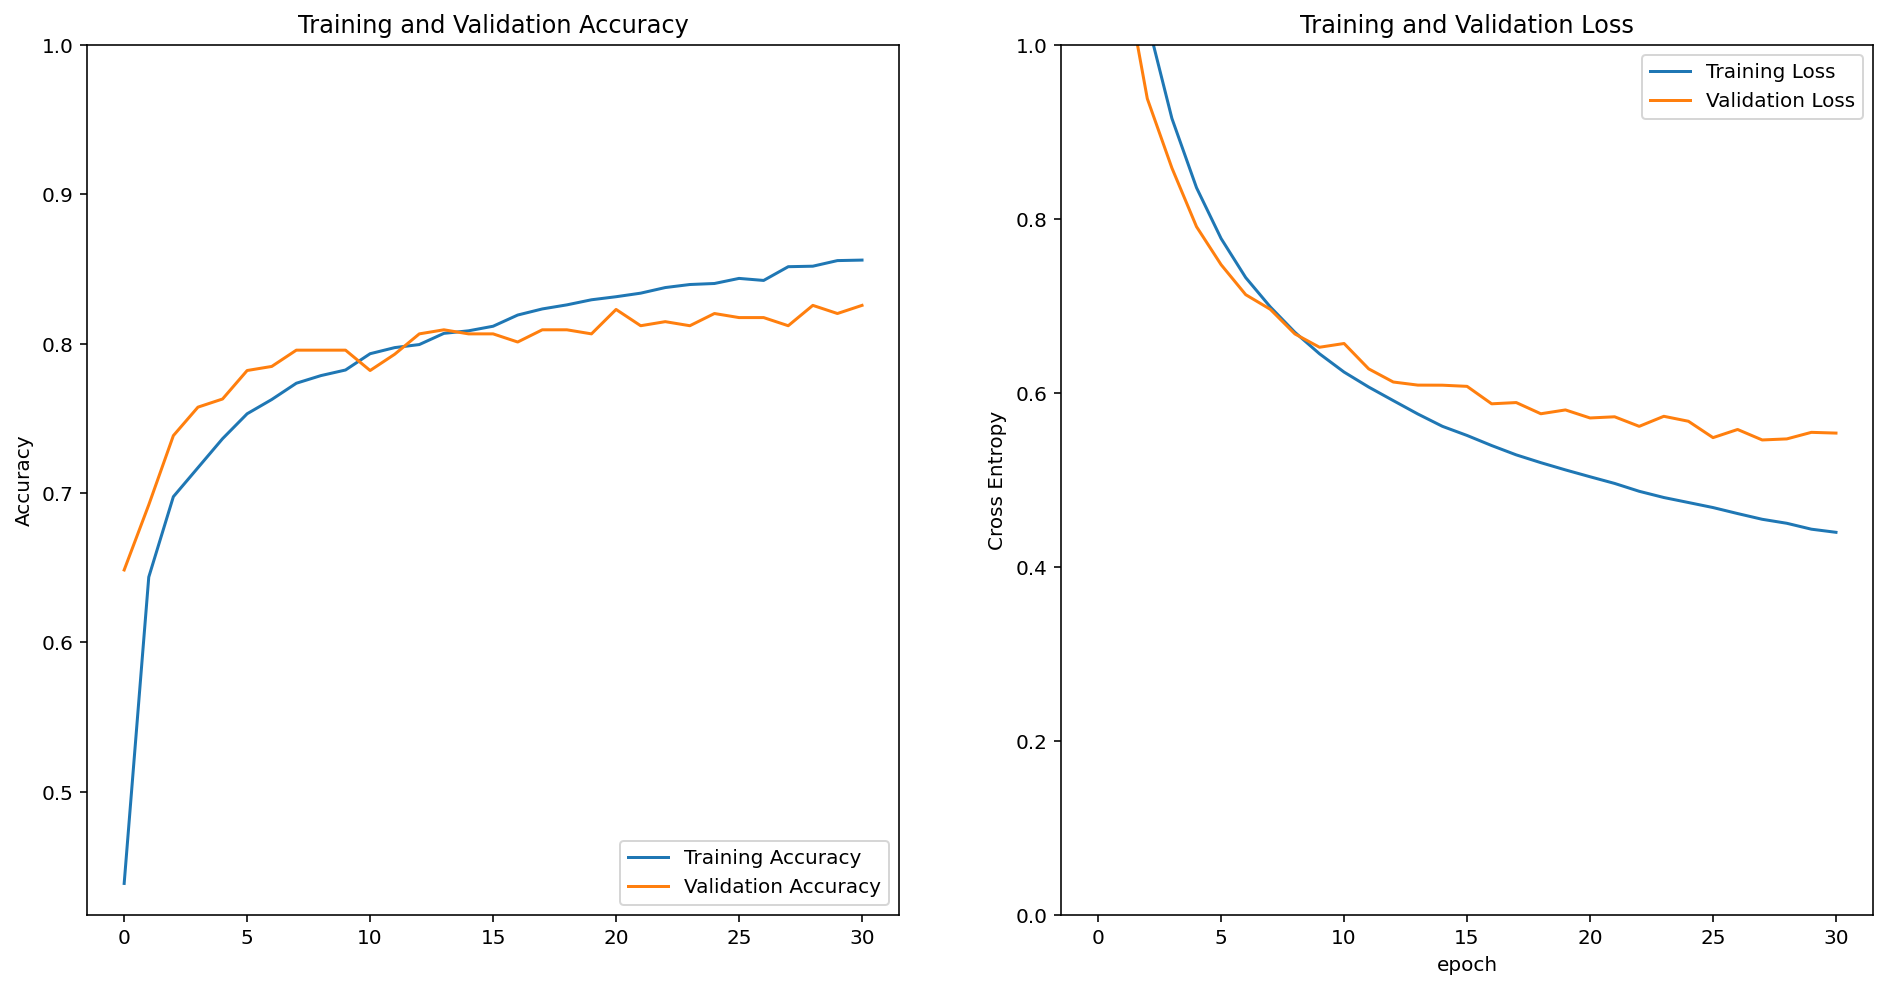

In [177]:
acc = history19_5.history['accuracy']
val_acc = history19_5.history['val_accuracy']

loss = history19_5.history['loss']
val_loss = history19_5.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [178]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# 체크포인트에서 모델을 로드
checkpoint_path = "vgg19_64_256256_0001.keras"
model19_1_1 = load_model(checkpoint_path)

# 로드된 모델을 사용하여 평가
test_loss, test_accuracy = model19_1_1.evaluate(test_batches)

# 결과 출력
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

import numpy as np

# tf.function으로 감싸서 retracing을 방지
@tf.function
def predict_batch(model, image_batch):
    return model(image_batch, training=False)

# 배치에서 이미지를 가져옴
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = predict_batch(model19_1_1, image_batch)
    break

# 예측값에서 가장 높은 확률의 인덱스를 가져옴
predictions = np.argmax(predictions, axis=1)

# 정답을 맞춘 개수를 계산
count = np.sum(labels.numpy() == predictions)

# 정확도 계산 및 출력
accuracy = count / len(labels) * 100
print(accuracy)

12/12 [==============================] - 1s 80ms/step - loss: 0.5463 - accuracy: 0.8174
Test Loss: 0.5462573170661926
Test Accuracy: 81.74%
84.375


### 6. dense layer 256*256, batch 32, learning rate 0.0001, dropout 0.3

In [181]:
BATCH_SIZE = 32  #한 스텝에 학습시킬 데이터의 개수
SHUFFLE_BUFFER_SIZE = 1000  #학습 데이터를 적절히 섞어줌

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [182]:
from tensorflow.keras.layers import Dense, Dropout

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Dropout을 적용하여 모델 구성
dense_layer_1 = Dense(units=256, activation='relu')
dropout_layer_1 = Dropout(rate=0.3)
dense_layer_2 = Dense(units=256, activation='relu')
dropout_layer_2 = Dropout(rate=0.3)
prediction_layer = Dense(units=5, activation='softmax')

# base_model을 제외한 레이어들을 연결
model19_6 = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense_layer_1,
    dropout_layer_1,
    dense_layer_2,
    dropout_layer_2,
    prediction_layer
])

base_model.trainable = False


In [183]:
model19_6 = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

learning_rate = 0.0001

model19_6.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [184]:
model19_6.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 5, 5, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_13  (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 1285      
Total params: 20,156,997
Trainable params: 132,613
Non-trainable params: 20,024,384
_________________________________________________________________


In [185]:
validation_steps=20
loss0, accuracy0 = model19_6.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

11/20 [===============>..............] - ETA: 0s - loss: 1.9664 - accuracy: 0.2841WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


20/20 [==============================] - 1s 46ms/step - loss: 1.9764 - accuracy: 0.2807
initial loss: 1.98
initial accuracy: 0.28


In [186]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

checkpoint_path = "vgg19_32_256256_0001_30.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=3, mode='min', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose =1)
]

history19_6 = model19_6.fit(train_batches,
                    epochs=50,
                    validation_data=validation_batches,
                    callbacks=keras_callbacks)

Epoch 1/50
92/92 [==============================] - 10s 97ms/step - loss: 1.4039 - accuracy: 0.4591 - val_loss: 1.1612 - val_accuracy: 0.6458

Epoch 00001: val_loss improved from inf to 1.16123, saving model to vgg19_32_256256_0001_30.keras
Epoch 2/50
92/92 [==============================] - 10s 98ms/step - loss: 1.0408 - accuracy: 0.6846 - val_loss: 0.9250 - val_accuracy: 0.7466

Epoch 00002: val_loss improved from 1.16123 to 0.92500, saving model to vgg19_32_256256_0001_30.keras
Epoch 3/50
92/92 [==============================] - 10s 100ms/step - loss: 0.8652 - accuracy: 0.7439 - val_loss: 0.8060 - val_accuracy: 0.7657

Epoch 00003: val_loss improved from 0.92500 to 0.80598, saving model to vgg19_32_256256_0001_30.keras
Epoch 4/50
92/92 [==============================] - 10s 100ms/step - loss: 0.7672 - accuracy: 0.7694 - val_loss: 0.7420 - val_accuracy: 0.7793

Epoch 00004: val_loss improved from 0.80598 to 0.74197, saving model to vgg19_32_256256_0001_30.keras
Epoch 5/50
92/92 [====

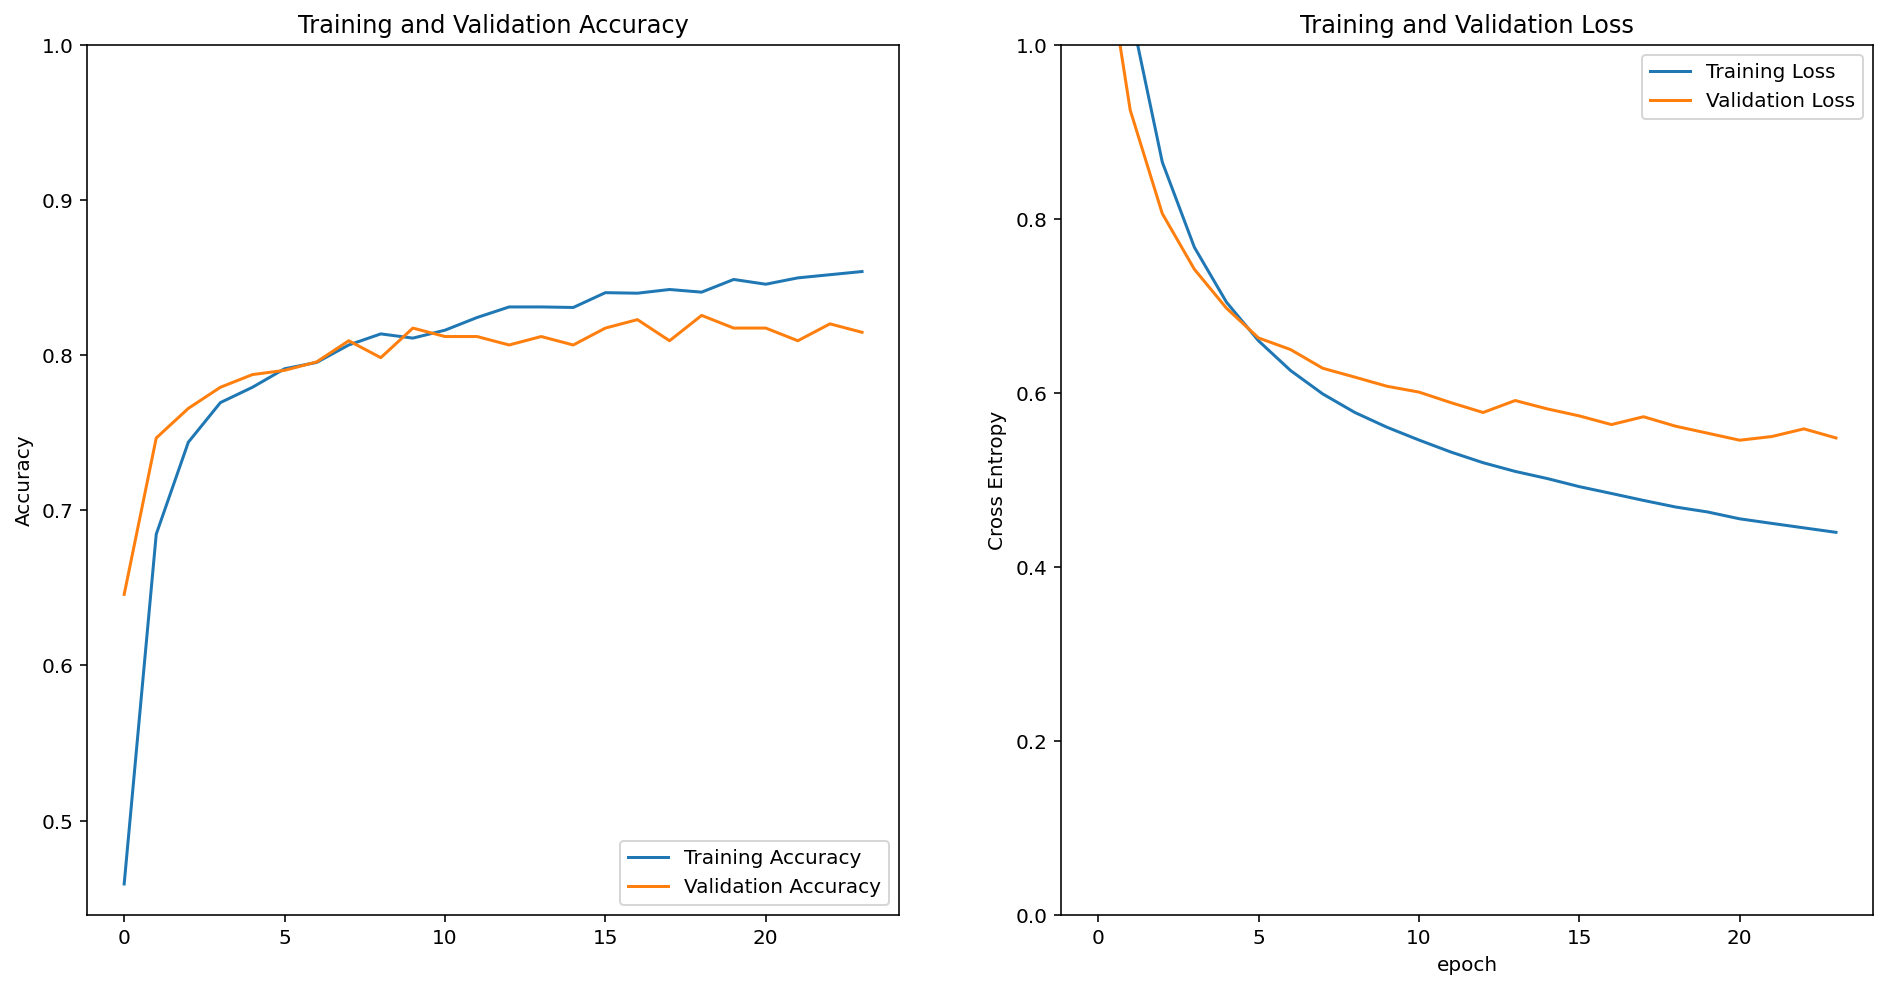

In [187]:
acc = history19_6.history['accuracy']
val_acc = history19_6.history['val_accuracy']

loss = history19_6.history['loss']
val_loss = history19_6.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [188]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# 체크포인트에서 모델을 로드
checkpoint_path = "vgg19_32_256256_0001_30.keras"
model= load_model(checkpoint_path)

# 로드된 모델을 사용하여 평가
test_loss, test_accuracy = model.evaluate(test_batches)

# 결과 출력
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

import numpy as np

# tf.function으로 감싸서 retracing을 방지
@tf.function
def predict_batch(model, image_batch):
    return model(image_batch, training=False)

# 배치에서 이미지를 가져옴
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = predict_batch(model, image_batch)
    break

# 예측값에서 가장 높은 확률의 인덱스를 가져옴
predictions = np.argmax(predictions, axis=1)

# 정답을 맞춘 개수를 계산
count = np.sum(labels.numpy() == predictions)

# 정확도 계산 및 출력
accuracy = count / len(labels) * 100
print(accuracy)

12/12 [==============================] - 1s 80ms/step - loss: 0.5619 - accuracy: 0.8065
Test Loss: 0.5619489550590515
Test Accuracy: 80.65%
81.25


### 7. dense 512, learning rate 0.0001, dropout 

In [189]:
BATCH_SIZE = 32  #한 스텝에 학습시킬 데이터의 개수
SHUFFLE_BUFFER_SIZE = 1000  #학습 데이터를 적절히 섞어줌

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [193]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                         include_top=False,  # classification layer을 빼고 불러오기 위해
                                         weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = Dense(units = 512, activation = 'relu')
dropout_layer= Dropout(rate=0.3)
prediction_layer = Dense(units = 5, activation = 'softmax')

# base_model을 제외한 레이어들을 연결
model19_7 = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense_layer,
    dropout_layer,
    prediction_layer
])

base_model.trainable = False


In [194]:
learning_rate = 0.0001

model19_7.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [195]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

checkpoint_path = "vgg19_00001_dropout30.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose =1)
]

history19_7 = model19_7.fit(train_batches,
                    epochs=50,
                    validation_data=validation_batches,
                    callbacks=keras_callbacks)

Epoch 1/50
92/92 [==============================] - 11s 98ms/step - loss: 1.4200 - accuracy: 0.4142 - val_loss: 1.2010 - val_accuracy: 0.6975

Epoch 00001: val_loss improved from inf to 1.20103, saving model to vgg19_00001_dropout30.keras
Epoch 2/50
92/92 [==============================] - 9s 98ms/step - loss: 1.1309 - accuracy: 0.6178 - val_loss: 0.9903 - val_accuracy: 0.7221

Epoch 00002: val_loss improved from 1.20103 to 0.99031, saving model to vgg19_00001_dropout30.keras
Epoch 3/50
92/92 [==============================] - 10s 100ms/step - loss: 0.9671 - accuracy: 0.6737 - val_loss: 0.8666 - val_accuracy: 0.7439

Epoch 00003: val_loss improved from 0.99031 to 0.86664, saving model to vgg19_00001_dropout30.keras
Epoch 4/50
92/92 [==============================] - 10s 100ms/step - loss: 0.8530 - accuracy: 0.7166 - val_loss: 0.7975 - val_accuracy: 0.7711

Epoch 00004: val_loss improved from 0.86664 to 0.79751, saving model to vgg19_00001_dropout30.keras
Epoch 5/50
92/92 [=============


Epoch 00036: val_loss improved from 0.52415 to 0.51911, saving model to vgg19_00001_dropout30.keras
Epoch 37/50
92/92 [==============================] - 9s 97ms/step - loss: 0.4020 - accuracy: 0.8631 - val_loss: 0.5277 - val_accuracy: 0.8202

Epoch 00037: val_loss did not improve from 0.51911
Epoch 38/50
92/92 [==============================] - 9s 98ms/step - loss: 0.3868 - accuracy: 0.8668 - val_loss: 0.5208 - val_accuracy: 0.8202

Epoch 00038: val_loss did not improve from 0.51911
Epoch 39/50
92/92 [==============================] - 9s 97ms/step - loss: 0.3850 - accuracy: 0.8696 - val_loss: 0.5184 - val_accuracy: 0.8174

Epoch 00039: val_loss improved from 0.51911 to 0.51836, saving model to vgg19_00001_dropout30.keras
Epoch 40/50
92/92 [==============================] - 9s 97ms/step - loss: 0.3843 - accuracy: 0.8661 - val_loss: 0.5145 - val_accuracy: 0.8283

Epoch 00040: val_loss improved from 0.51836 to 0.51446, saving model to vgg19_00001_dropout30.keras
Epoch 41/50
92/92 [======

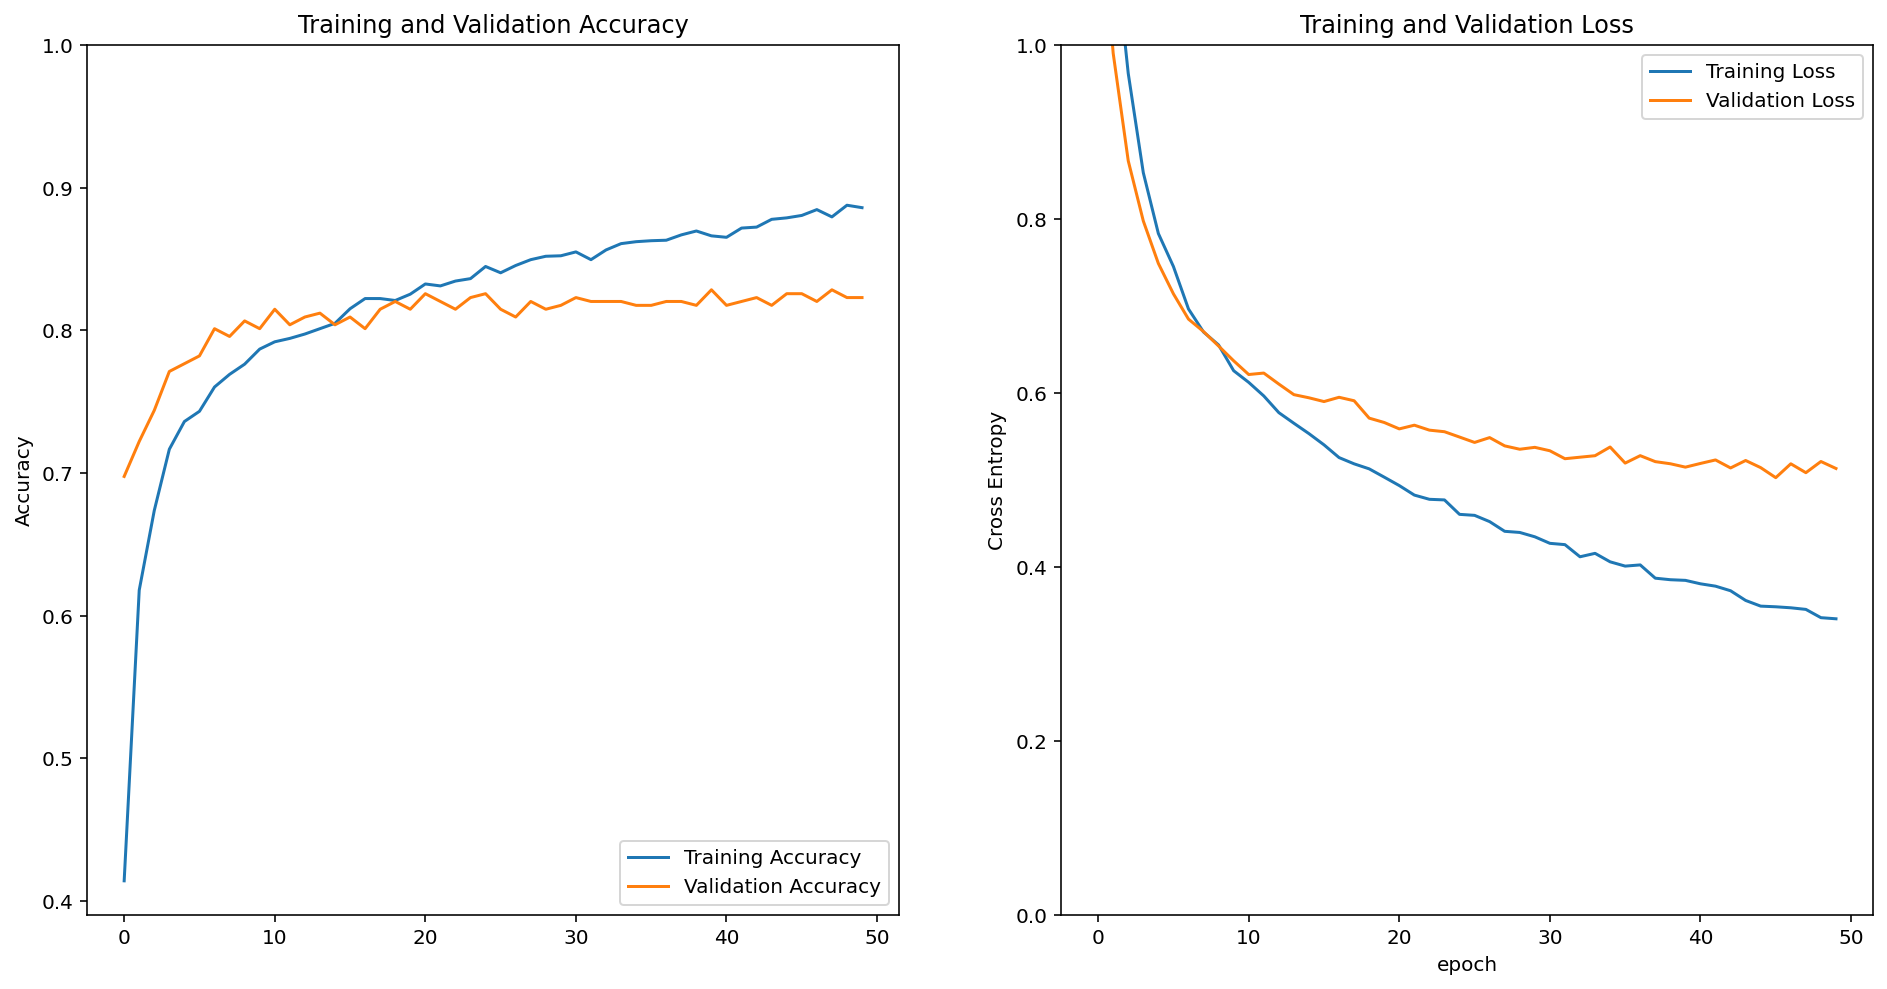

In [196]:
acc = history19_7.history['accuracy']
val_acc = history19_7.history['val_accuracy']

loss = history19_7.history['loss']
val_loss = history19_7.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [197]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# 체크포인트에서 모델을 로드
checkpoint_path = "vgg19_00001_dropout30.keras"
model= load_model(checkpoint_path)

# 로드된 모델을 사용하여 평가
test_loss, test_accuracy = model.evaluate(test_batches)

# 결과 출력
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

import numpy as np

# tf.function으로 감싸서 retracing을 방지
@tf.function
def predict_batch(model, image_batch):
    return model(image_batch, training=False)

# 배치에서 이미지를 가져옴
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = predict_batch(model, image_batch)
    break

# 예측값에서 가장 높은 확률의 인덱스를 가져옴
predictions = np.argmax(predictions, axis=1)

# 정답을 맞춘 개수를 계산
count = np.sum(labels.numpy() == predictions)

# 정확도 계산 및 출력
accuracy = count / len(labels) * 100
print(accuracy)

12/12 [==============================] - 1s 77ms/step - loss: 0.4988 - accuracy: 0.8174
Test Loss: 0.4988168478012085
Test Accuracy: 81.74%
84.375


### 8. dense 512, learning rate 0.0001, regularization

In [198]:
BATCH_SIZE = 32  #한 스텝에 학습시킬 데이터의 개수
SHUFFLE_BUFFER_SIZE = 1000  #학습 데이터를 적절히 섞어줌

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [199]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# L2 정규화 적용
dense_layer = Dense(units=512, activation='relu', kernel_regularizer=l2(0.01))  # L2 정규화 인자 설정
prediction_layer = Dense(units=5, activation='softmax', kernel_regularizer=l2(0.01))  # L2 정규화 인자 설정

# base_model을 제외한 레이어들을 연결
model19_8 = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense_layer,
    prediction_layer
])

base_model.trainable = False

In [200]:
learning_rate = 0.0001

model19_8.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [201]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

checkpoint_path = "vgg19_00001_l2.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose =1)
]

history19_8 = model19_8.fit(train_batches,
                    epochs=50,
                    validation_data=validation_batches,
                    callbacks=keras_callbacks)

Epoch 1/50
92/92 [==============================] - 10s 99ms/step - loss: 5.8785 - accuracy: 0.5160 - val_loss: 5.0920 - val_accuracy: 0.6921

Epoch 00001: val_loss improved from inf to 5.09201, saving model to vgg19_00001_l2.keras
Epoch 2/50
92/92 [==============================] - 9s 98ms/step - loss: 4.5187 - accuracy: 0.6700 - val_loss: 3.9610 - val_accuracy: 0.6866

Epoch 00002: val_loss improved from 5.09201 to 3.96101, saving model to vgg19_00001_l2.keras
Epoch 3/50
92/92 [==============================] - 10s 100ms/step - loss: 3.5228 - accuracy: 0.7057 - val_loss: 3.0886 - val_accuracy: 0.7493

Epoch 00003: val_loss improved from 3.96101 to 3.08860, saving model to vgg19_00001_l2.keras
Epoch 4/50
92/92 [==============================] - 10s 100ms/step - loss: 2.7804 - accuracy: 0.7279 - val_loss: 2.4723 - val_accuracy: 0.7493

Epoch 00004: val_loss improved from 3.08860 to 2.47226, saving model to vgg19_00001_l2.keras
Epoch 5/50
92/92 [==============================] - 9s 98ms

Epoch 37/50
92/92 [==============================] - 9s 98ms/step - loss: 0.8763 - accuracy: 0.8096 - val_loss: 0.9087 - val_accuracy: 0.7902

Epoch 00037: val_loss improved from 0.91599 to 0.90875, saving model to vgg19_00001_l2.keras
Epoch 38/50
92/92 [==============================] - 9s 97ms/step - loss: 0.8723 - accuracy: 0.8134 - val_loss: 0.9142 - val_accuracy: 0.7984

Epoch 00038: val_loss did not improve from 0.90875
Epoch 39/50
92/92 [==============================] - 9s 97ms/step - loss: 0.8694 - accuracy: 0.8116 - val_loss: 0.9242 - val_accuracy: 0.7956

Epoch 00039: val_loss did not improve from 0.90875
Epoch 40/50
92/92 [==============================] - 9s 98ms/step - loss: 0.8684 - accuracy: 0.8127 - val_loss: 0.9027 - val_accuracy: 0.7956

Epoch 00040: val_loss improved from 0.90875 to 0.90268, saving model to vgg19_00001_l2.keras
Epoch 41/50
92/92 [==============================] - 9s 97ms/step - loss: 0.8654 - accuracy: 0.8164 - val_loss: 0.9195 - val_accuracy: 0.809

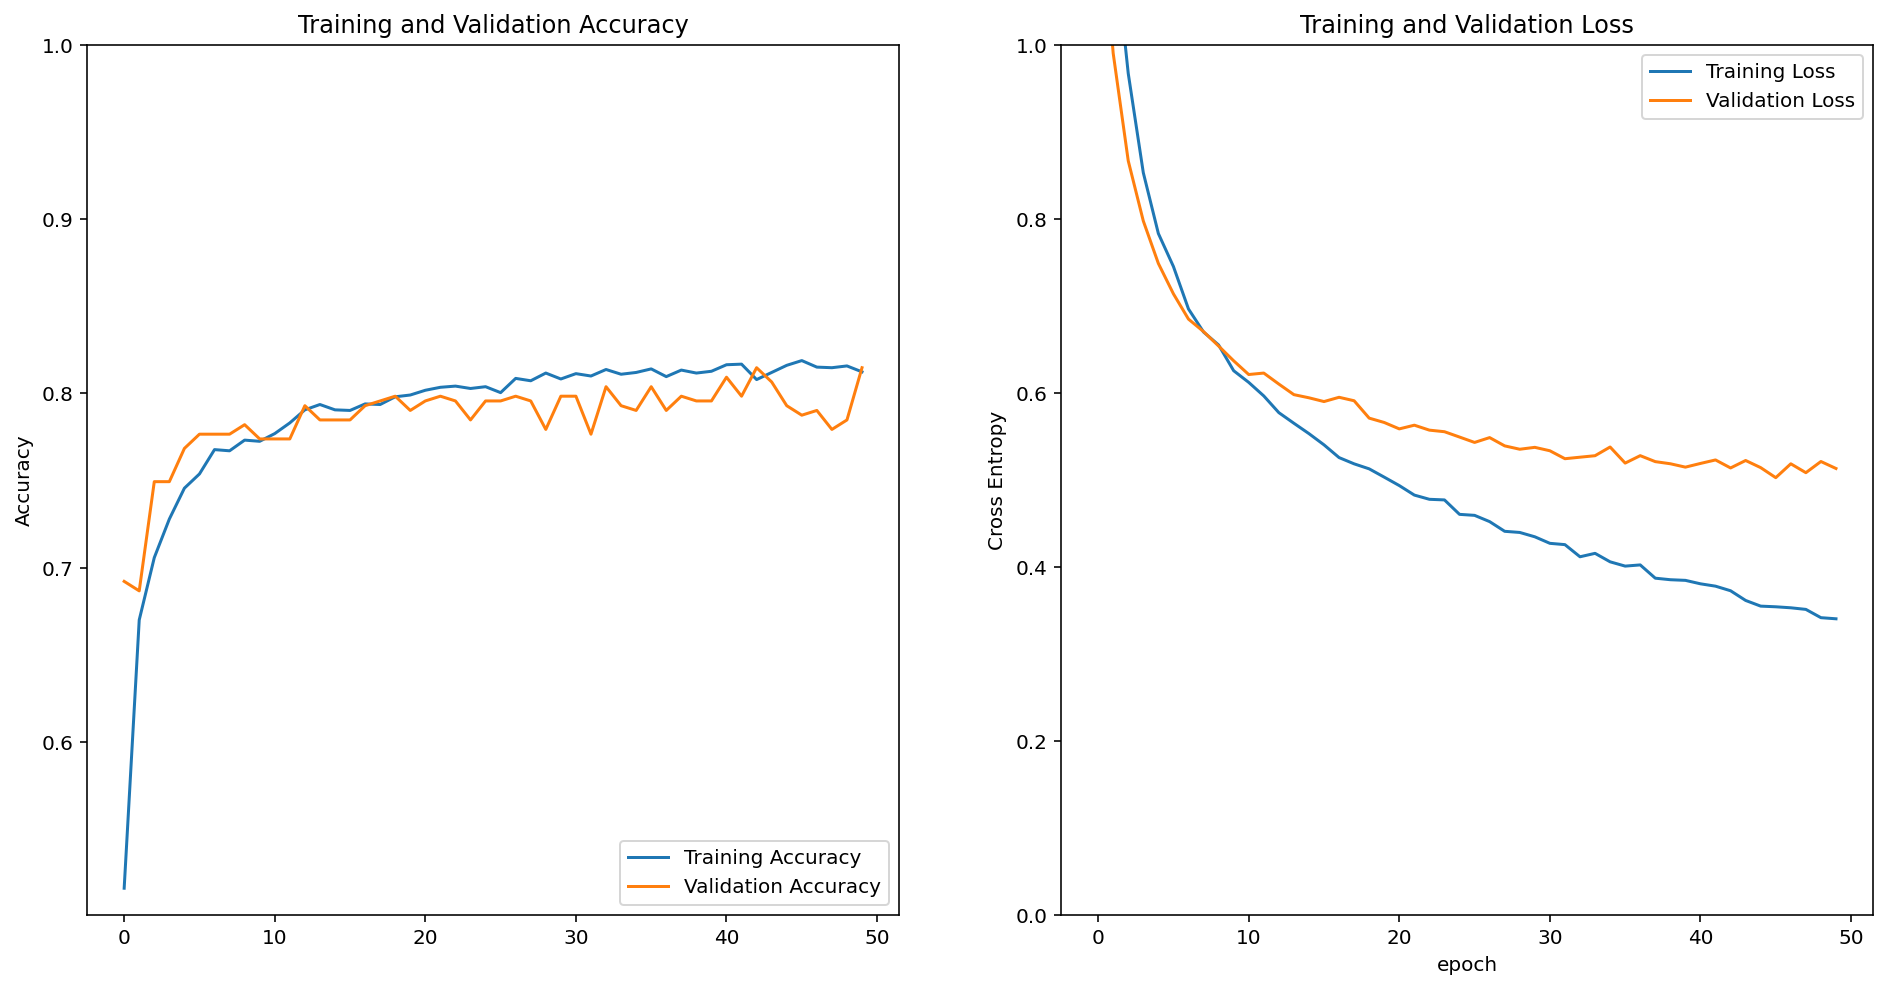

In [202]:
acc = history19_8.history['accuracy']
val_acc = history19_8.history['val_accuracy']

loss = history19_7.history['loss']
val_loss = history19_7.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [204]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# 체크포인트에서 모델을 로드
checkpoint_path = "vgg19_00001_l2.keras"
model= load_model(checkpoint_path)

# 로드된 모델을 사용하여 평가
test_loss, test_accuracy = model.evaluate(test_batches)

# 결과 출력
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

import numpy as np

# tf.function으로 감싸서 retracing을 방지
@tf.function
def predict_batch(model, image_batch):
    return model(image_batch, training=False)

# 배치에서 이미지를 가져옴
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = predict_batch(model, image_batch)
    break

# 예측값에서 가장 높은 확률의 인덱스를 가져옴
predictions = np.argmax(predictions, axis=1)

# 정답을 맞춘 개수를 계산
count = np.sum(labels.numpy() == predictions)

# 정확도 계산 및 출력
accuracy = count / len(labels) * 100
print(accuracy)

12/12 [==============================] - 1s 77ms/step - loss: 0.9401 - accuracy: 0.7684
Test Loss: 0.9401364922523499
Test Accuracy: 76.84%
84.375
